In [1]:
#python specific stuff
import numpy as np
import matplotlib.pyplot as plt
import time
from functions import *
from ReadInParameters import *


In [2]:
## INITIALIZATION for time
total_time_h=1 #hours
t_step=0.1 #s
total_time_s=total_time_h*60*60
N_t_steps=int(total_time_s/t_step)

In [3]:
# # UPPER ROOM INITIALIZATION #########################
[lower,middle,upper,output_surface_array_lower,output_surface_array_middle,output_surface_array_upper,T_target,T_exterior,target_level]=ReadInParameters('UserInputSheet.xlsx')


## DO CALCULATION ##################

data_array_T_room_upper=np.zeros(int(N_t_steps))
data_array_T_room_middle=np.zeros(int(N_t_steps))
data_array_T_room_lower=np.zeros(int(N_t_steps))
data_array_surfaces=np.zeros([int(N_t_steps),10])
Qin_cumul=[0]

for t in range(N_t_steps):
    
    #data input for plotting

    data_array_T_room_upper[t]=upper.T_room
    data_array_T_room_middle[t]=middle.T_room
    data_array_T_room_lower[t]=lower.T_room
    data_array=[]
    for output_surface in output_surface_array_upper:
            data_array=np.append(data_array,output_surface.T_array[0])
    for output_surface in output_surface_array_middle:
            data_array=np.append(data_array,output_surface.T_array[0])
    for output_surface in output_surface_array_lower:
            data_array=np.append(data_array,output_surface.T_array[0])
            
    data_array_surfaces[t,:]=data_array
    
    ## LAYER 1
    
    #do surfaces in upper room
    [Qout_room_total,output_surface_array_upper]=do_surfaces_in_room(output_surface_array_upper,upper.T_room,t_step,T_exterior)
    #now conductive to lower room
    Qout_upper_to_middle=calculate_Qout_convective(upper.U,upper.area,upper.T_room,middle.T_room)
    Qout_room_total=Qout_room_total+Qout_upper_to_middle
    
    #temp monitoring - for now NO CHANGE

    if lower.T_room >= T_target:
        upper.Qin=1*upper.Qin_max
        middle.Qin=1*middle.Qin_max
        lower.Qin=1*lower.Qin_max
    else:
        upper.Qin=upper.Qin_max
        middle.Qin=middle.Qin_max
        lower.Qin=lower.Qin_max
    
    #update Temp of room using Qins and Qouts
    Q_leak_upper=upper.airchanges_per_hour*upper.volume*t_step*upper.densityC*(upper.T_room-T_exterior)/3600
    upper.T_room=upper.T_room+calculate_Tchange(upper.Qin-Q_leak_upper,Qout_room_total,t_step,upper.densityC,upper.volume)
    
    
    ## LAYER 2
    ##bug here in line 43
    [Qout_room_total,output_surface_array_middle]=do_surfaces_in_room(output_surface_array_middle,middle.T_room,t_step,T_exterior)
    Qout_middle_to_lower=calculate_Qout_convective(middle.U,middle.area,middle.T_room,lower.T_room)
    Qout_room_total=Qout_room_total+Qout_middle_to_lower
    
    #Calculate cumulative heat input:
    Q_leak_middle=middle.airchanges_per_hour*middle.volume*t_step*middle.densityC*(middle.T_room-T_exterior)/3600
    middle.T_room=middle.T_room+calculate_Tchange(middle.Qin+Qout_upper_to_middle-Q_leak_middle,Qout_room_total,t_step,middle.densityC,middle.volume)
    
    ## LAYER 3
    
    [Qout_room_total,output_surface_array_lower]=do_surfaces_in_room(output_surface_array_lower,lower.T_room,t_step,T_exterior)

    #Calculate cumulative heat input:
    Q_leak_lower=lower.airchanges_per_hour*lower.volume*t_step*lower.densityC*(lower.T_room-T_exterior)/3600
    lower.T_room=lower.T_room+calculate_Tchange(lower.Qin+Qout_middle_to_lower-Q_leak_lower,Qout_room_total,t_step,lower.densityC,lower.volume)
    ## CUMUL Q
    
    #Qin_cumul=np.append(Qin_cumul,Qin_cumul[t]+lower.Qin*t_step +middle.Qin*t_step+upper.Qin*t_step)  

C:\Users\philh\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


3.4885776858800073


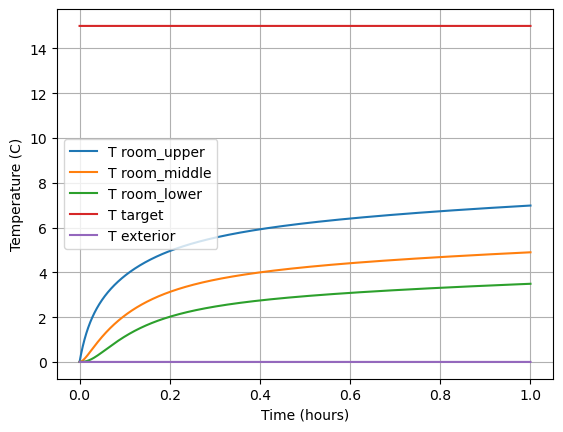

In [4]:
# MAKE PLOTS ##########################

t_array=np.arange(0,N_t_steps*t_step,t_step)/(60*60)
plt.plot(t_array,data_array_T_room_upper,label='T room_upper')
plt.plot(t_array,data_array_T_room_middle,label='T room_middle')
plt.plot(t_array,data_array_T_room_lower,label='T room_lower')
plt.plot(t_array,np.full(N_t_steps,T_target),label='T target')
plt.plot(t_array,np.full(N_t_steps,T_exterior),label='T exterior')
plt.legend()
plt.grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')
print(data_array_T_room_lower[-1])

Text(0.5, 1.0, 'Upper')

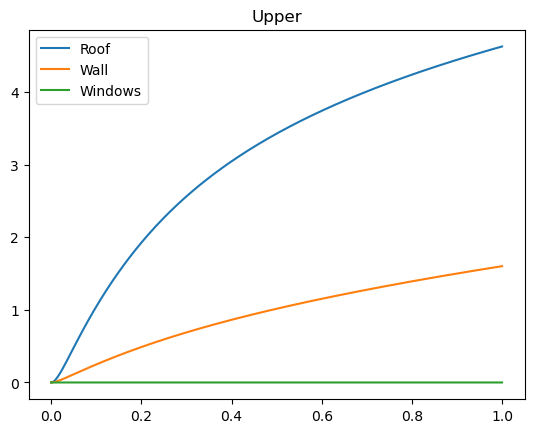

In [5]:
lineObjects =plt.plot(t_array,data_array_surfaces[:,0:3])
plt.legend(iter(lineObjects), ('Roof','Wall','Windows'))
plt.title('Upper')


Text(0.5, 1.0, 'Middle')

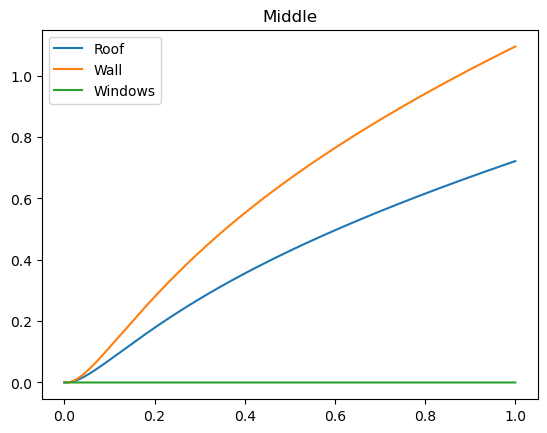

In [6]:
lineObjects =plt.plot(t_array,data_array_surfaces[:,3:6])
plt.legend(iter(lineObjects), ('Roof','Wall','Windows'))
plt.title('Middle')

Text(0.5, 1.0, 'Lower')

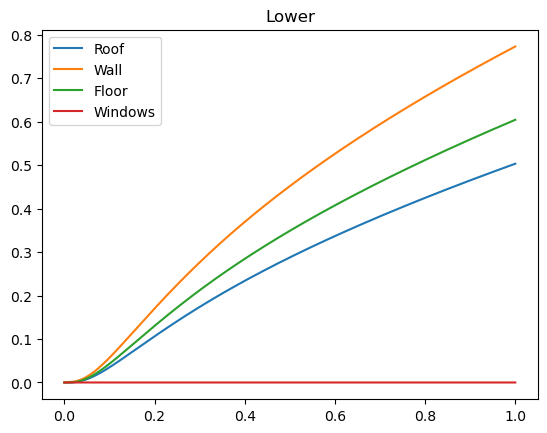

In [7]:
lineObjects =plt.plot(t_array,data_array_surfaces[:,6:10])
plt.legend(iter(lineObjects), ('Roof','Wall','Floor','Windows'))
plt.title('Lower')